In [1]:
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import os
import numpy as np

os.chdir('../..')

from src.utils import *
from src.utility import merge_speed_events

In [ ]:
speeds_df = pd.read_csv(resources_path('dataset', 'preprocessed', 'speeds_train_imputed_time.csv.gz'))
events_df = pd.read_csv(resources_path('dataset', 'preprocessed', 'events_train.csv.gz'))
sensors_df = pd.read_csv(resources_path('dataset', 'originals', 'sensors.csv.gz'))
speeds_df.shape

In [ ]:
speeds_df.dropna(inplace=True)
speeds_df.shape

In [ ]:
speeds_events_df = merge_speed_events(speeds_df, events_df)
speeds_events_df.shape

In [ ]:
speeds_events_df = pd.merge(speeds_events_df, sensors_df, left_on=[KEY, KM], right_on=[KEY, KM], how='left')
speeds_events_df = speeds_events_df[[KEY, KM, DATETIME, SPEED_AVG, N_CARS, 'IMPUTED', EVENT_TYPE, KM_END, KM_START, 'KM_EVENT', 'step_duration', ROAD_TYPE, LANES, 'EMERGENCY_LANE']]
speeds_events_df.head(4)

In [ ]:
idx = speeds_events_df['KM_EVENT'].isnull()
speeds_events_df.loc[idx, 'KM_EVENT'] = speeds_events_df.loc[idx, 'KM_START'] + (speeds_events_df.loc[idx, 'KM_END'] - speeds_events_df.loc[idx, 'KM_START'])/2
speeds_events_df.head(4)

In [ ]:
speeds_events_df['DISTANCE'] = speeds_events_df['KM_EVENT'] - speeds_events_df[KM]
speeds_events_df = speeds_events_df[[KEY, KM, DATETIME, SPEED_AVG, N_CARS, 'IMPUTED', EVENT_TYPE, 'DISTANCE', 'step_duration']]
speeds_events_df.head(4)

In [ ]:
min_time = pd.to_datetime(speeds_events_df.DATETIME_UTC).astype('int').min()
min_time = (min_time//(10**9))//60
# speeds_events_df[DATETIME] = ((pd.to_datetime(speeds_events_df.DATETIME_UTC).astype('int')//(10**9))//60 - min_time)//15
speeds_events_df.head(4)

In [ ]:
speeds_events_df[EVENT_TYPE] = speeds_events_df.EVENT_TYPE.fillna('no_event')
speeds_events_df[DISTANCE] = speeds_events_df.DISTANCE.fillna(0)
speeds_events_df['step_duration'] = speeds_events_df.step_duration.fillna(0)
speeds_events_df.sort_values(DATETIME).head()

In [ ]:
speeds_events_onehot_df = pd.concat([speeds_events_df, pd.get_dummies(speeds_events_df[EVENT_TYPE])], axis=1)

In [ ]:
speeds_events_onehot_df.drop('EVENT_TYPE', axis=1, inplace=True)
speeds_events_onehot_df.head(4)

In [ ]:
final_df = speeds_events_onehot_df.groupby([KEY, KM, DATETIME, SPEED_AVG, N_CARS, 'IMPUTED', 'DISTANCE', 'step_duration']).sum().reset_index()
final_df[final_df[DISTANCE] > 0.0].head(10)

In [ ]:
final_df.drop_duplicates([KEY, KM, DATETIME], inplace=True)
final_df.shape

In [ ]:
final_df.sort_values([KEY, KM, DATETIME], inplace=True)
final_df = final_df.loc[:, ~final_df.columns.str.contains('^Unnamed')]
final_df.to_csv(resources_path('dataset', 'training', 'train_2.csv.gz'))

## Fitting some models

In [3]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [31]:
df = pd.read_csv(resources_path('dataset', 'training', 'train_2.csv.gz'))
sensors_df = pd.read_csv(resources_path('dataset', 'originals', 'sensors.csv.gz'))
df.head(5)

,Unnamed: 0,KEY,KM,DATETIME_UTC,SPEED_AVG,N_VEHICLES,IMPUTED,DISTANCE,step_duration,Allarme,...,Meteo,Opera_arte,Ostacolo_in_carreggiata,Pavimentazione,Regimazione_delle_acque,Segnaletica_orizzontale,Segnaletica_verticale,Veicolo_in_avaria,extended_accident,no_event
0,0,0.0,333,2018-09-01 00:00:00,231.125907,150.0,False,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,2
1,1,0.0,333,2018-09-01 00:15:00,225.915947,225.0,False,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,2
2,2,0.0,333,2018-09-01 00:30:00,228.498770,148.0,False,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,2
3,3,0.0,333,2018-09-01 00:45:00,231.562904,197.0,False,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,2
4,4,0.0,333,2018-09-01 01:00:00,229.282707,147.0,False,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,2


In [32]:
sensors_df.head(5)

,KEY,EMERGENCY_LANE,KM,LANES,ROAD_TYPE
0,44.0,0,1410,2,0
1,146.0,0,1473,2,0
2,53.0,0,1421,2,0
3,122.0,0,679,2,0
4,17.0,1,1399,3,1


In [33]:
df_1 = df[(df[KEY] == 0) & (df[KM] == 333)]
df_1.sort_values(DATETIME).head(5)

,Unnamed: 0,KEY,KM,DATETIME_UTC,SPEED_AVG,N_VEHICLES,IMPUTED,DISTANCE,step_duration,Allarme,...,Meteo,Opera_arte,Ostacolo_in_carreggiata,Pavimentazione,Regimazione_delle_acque,Segnaletica_orizzontale,Segnaletica_verticale,Veicolo_in_avaria,extended_accident,no_event
0,0,0.0,333,2018-09-01 00:00:00,231.125907,150.0,False,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,2
1,1,0.0,333,2018-09-01 00:15:00,225.915947,225.0,False,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,2
2,2,0.0,333,2018-09-01 00:30:00,228.498770,148.0,False,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,2
3,3,0.0,333,2018-09-01 00:45:00,231.562904,197.0,False,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,2
4,4,0.0,333,2018-09-01 01:00:00,229.282707,147.0,False,0.0,0.0,0,...,0,0,0,0,0,0,0,0,0,2


In [34]:
df_1.shape

(8073, 25)

In [35]:
y = df_1[[DATETIME, SPEED_AVG]].set_index(DATETIME)
u = df_1.drop([KEY, KM, SPEED_AVG, 'IMPUTED'], axis=1)
u = u.loc[:, ~u.columns.str.contains('^Unnamed')]
u = df_1.N_VEHICLES
u.set_index(DATETIME, inplace=True)
u.head(10)

AttributeError: 'Series' object has no attribute 'set_index'

In [37]:
y.head()

,SPEED_AVG
DATETIME_UTC,
2018-09-01 00:00:00,231.125907
2018-09-01 00:15:00,225.915947
2018-09-01 00:30:00,228.498770
2018-09-01 00:45:00,231.562904
2018-09-01 01:00:00,229.282707


In [40]:
u = np.array(u)
print(y.shape)
print(u.shape)
y_train = y[0:7000]
u = u[0:7000]
u_test = u[7000:]
y_test = y[7000:]

(8073, 1)
(8073,)


In [41]:
armax = sm.tsa.ARMA(y_train, exog=u, order=(16, 8))

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [42]:
results_model = armax.fit(trend='nc', method='mle', maxiter=5)

/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [43]:
results_model.summary()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:1455: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
/opt/conda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:              SPEED_AVG   No. Observations:                 7000
Model:                    ARMA(16, 8)   Log Likelihood              -27027.276
Method:                           mle   S.D. of innovations             11.494
Date:                Tue, 28 May 2019   AIC                          54106.551
Time:                        19:39:28   BIC                          54284.747
Sample:                             0   HQIC                         54167.955
                                                                              
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
x1                  -0.0505      0.002    -20.329      0.000      -0.055      -0.046
ar.L1.SPEED_AVG      0.2223        nan        nan        nan         nan         nan
ar.L2.SPEED_AVG      0.2413        nan        nan        nan         nan         nan
ar.L3.SPEED_AVG      0.1763        nan        nan        nan         nan         nan
ar.L4.SPEED_AVG      0.1407        nan        nan        nan         nan         nan
ar.L5.SPEED_AVG      0.0620      0.091      0.682      0.496      -0.116       0.240
ar.L6.SPEED_AVG      0.0281        nan        nan        nan         nan         nan
ar.L7.SPEED_AVG      0.0025        nan        nan        nan         nan         nan
ar.L8.SPEED_AVG     -0.0046      0.156     -0.029      0.977      -0.311       0.302
ar.L9.SPEED_AVG      0.0084        nan        nan        nan         nan         nan
ar.L10.SPEED_AVG    -0.0161        nan        nan        nan         nan         nan
ar.L11.SPEED_AVG     0.0054        nan        nan        nan         nan         nan
ar.L12.SPEED_AVG    -0.0223        nan        nan        nan         nan         nan
ar.L13.SPEED_AVG     0.0218      0.015      1.474      0.141      -0.007       0.051
ar.L14.SPEED_AVG     0.0206      0.009      2.295      0.022       0.003       0.038
ar.L15.SPEED_AVG     0.0378      0.002     25.053      0.000       0.035       0.041
ar.L16.SPEED_AVG     0.0699      0.008      8.553      0.000       0.054       0.086
ma.L1.SPEED_AVG      0.1682        nan        nan        nan         nan         nan
ma.L2.SPEED_AVG      0.0603        nan        nan        nan         nan         nan
ma.L3.SPEED_AVG      0.0152        nan        nan        nan         nan         nan
ma.L4.SPEED_AVG      0.0349        nan        nan        nan         nan         nan
ma.L5.SPEED_AVG      0.0329      0.076      0.432      0.666      -0.117       0.182
ma.L6.SPEED_AVG      0.0180        nan        nan        nan         nan         nan
ma.L7.SPEED_AVG      0.0317      0.038      0.829      0.407      -0.043       0.107
ma.L8.SPEED_AVG      0.0330      0.068      0.489      0.625      -0.099       0.165
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1             1.0014           -0.0000j            1.0014           -0.0000
AR.2             1.0772           -0.3645j            1.1372           -0.0519
AR.3             1.0772           +0.3645j            1.1372            0.0519
AR.4             0.8277           -0.8409j            1.1800           -0.1263
AR.5             0.8277           +0.8409j            1.1800            0.1263
AR.6             0.4188           -1.1196j            1.1954           -0.1930
AR.7             0.4188           +1.1196j            1.1954           

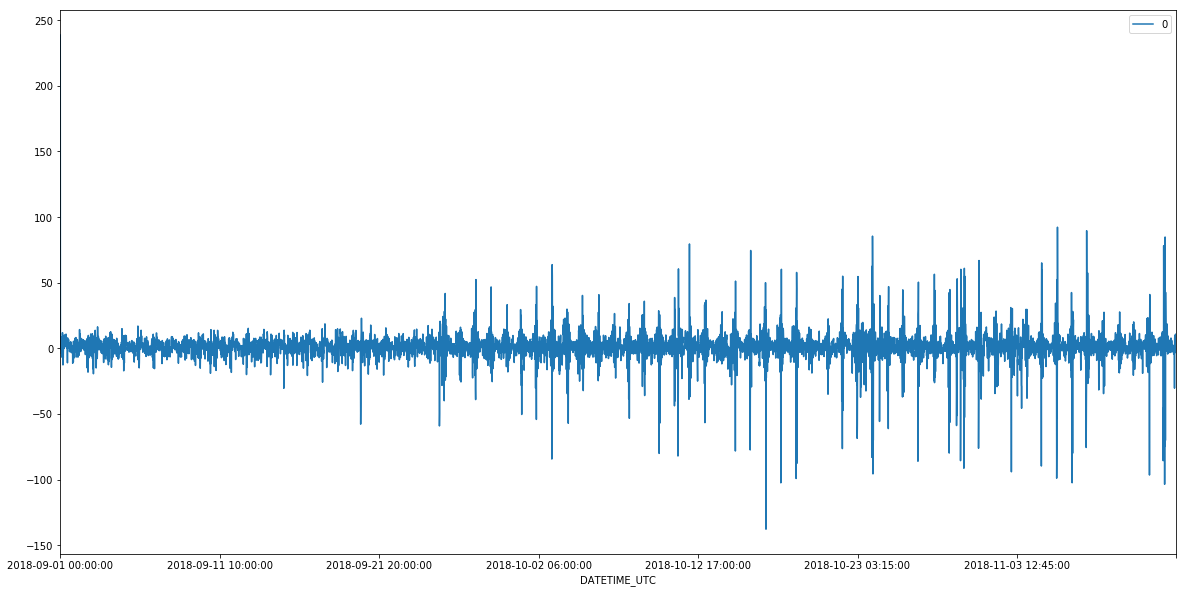

In [44]:
residuals = pd.DataFrame(results_model.resid)
residuals.plot(figsize=(20, 10))
plt.show()

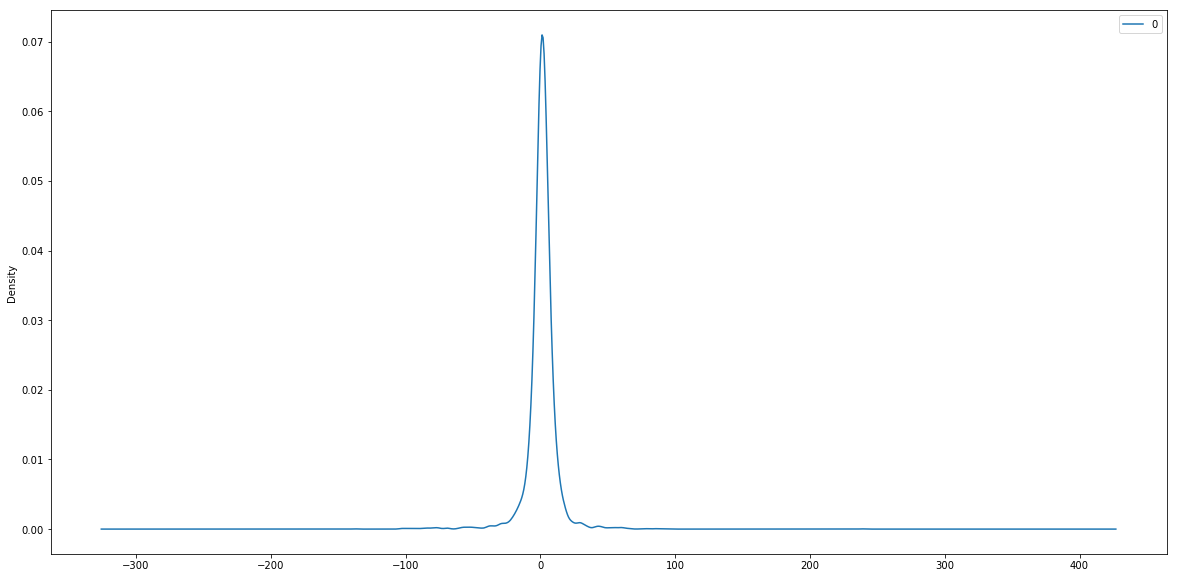

In [45]:
residuals.plot(figsize=(20, 10), kind='kde');

In [46]:
residuals.describe()

,0
count,7000.000000
mean,1.053648
std,11.787862
min,-137.660068
25%,-2.184935
50%,1.408015
75%,5.035216
max,238.703784


In [50]:
predicted = results_model.forecast(steps=len(y_test), exog=u_test)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
predicted[0].shape

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(y_test[0:100])
plt.plot(predicted[0][0:100], color='red')
plt.show()